# Introduction

This project entails transforming motion data from a wrist wearable into medical insights.
To support this project, 6 csv files were used, totalling at 4 kB. These can be found inside the `recordings` folder.

The goals were to identify Parkinson's tremors, as well as arm swings, and to research and answer three questions.

#### Background information
Parkinsonian tremors: although the amplitude of tremors may vary, its frequency will generally remain between 4 and 6 Hz

Armswing: Asymmetric arm swings during walks is a symptom of Parkinson's disease, being able to identify and quantify them is very valuable to doctors.

The data comes from 3 sensors: gyroscope, accelerometer, and magnetometer, each in three different axes. The sampling frequency of every sensor is the same: **50 Hz**. The `TS` column gives us a way to check for missing samples, as it's incremented at every step (and ranges from 0 to 255).

# Data exploration

In this section, I explore the data received, visualise some measurements, and check for missing values.

In [1]:
import os
import time
import numpy as np
import scipy as sp
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

Let's read all the recordings and put them in a list.

In [15]:
recording_fs = os.listdir('recordings/')
raw_recordings = []

for f in recording_fs:
    data = pd.read_csv('recordings/' + f, error_bad_lines=False)
    data = data.drop_duplicates()
    raw_recordings.append(data)
    
raw_recordings[0].head()

b'Skipping line 939: expected 10 fields, saw 19\n'


,GX,GY,GZ,AX,AY,AZ,MX,MY,MZ,TS
0,-47.576904,9.704590,124.64905,-0.088623,0.427490,0.862061,-0.186035,-0.072876,-0.139160,186
1,-47.607420,15.594482,130.47790,-0.095947,0.421875,0.871338,-0.186035,-0.072876,-0.139160,187
2,-44.570923,10.726929,136.13892,-0.095947,0.409424,0.906006,-0.189331,-0.078369,-0.140991,188
3,-41.625977,-1.327515,136.03210,-0.087891,0.387451,0.943359,-0.189331,-0.078369,-0.140991,189
4,-45.120240,-21.636963,127.01416,-0.046875,0.347900,0.974609,-0.189331,-0.078369,-0.140991,190


First of all, I need to understand the three types of measurements and how they vary over time. For this, I will create three plots, one for each type. The recording which is visualised can be easily changed by changing the argument to `plot_all_measurement`.

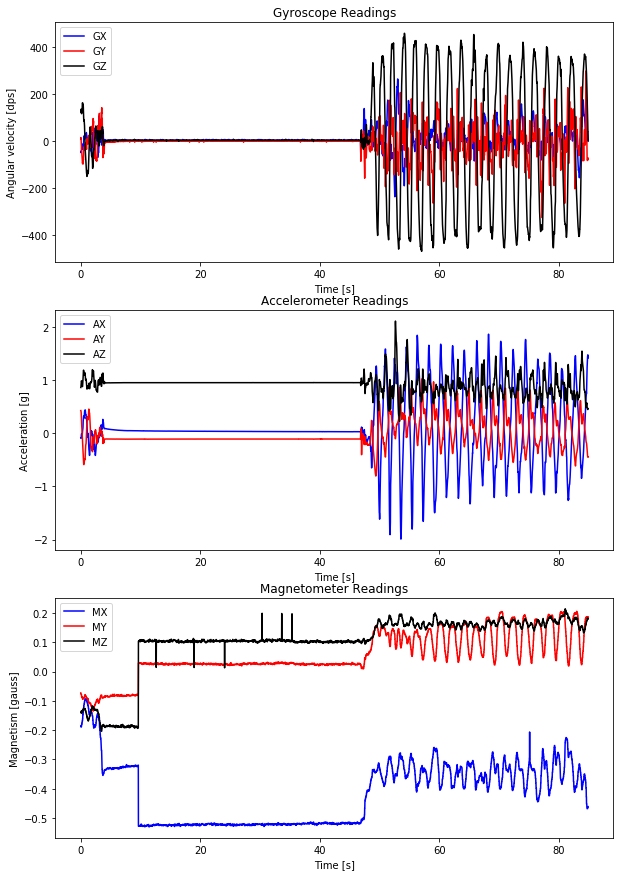

In [16]:
plot_titles = ['Gyroscope', 'Accelerometer', 'Magnetometer']
ylabels = ['Angular velocity [dps]', 'Acceleration [g]', 'Magnetism [gauss]']
sampling_freq = 50

def separate_dimensions(names):
    names = np.array(names[:-1]) # drop TS column
    new_dim = (int(names.shape[0]/3), 3)
    return names.reshape(new_dim)


def plot_one_measurement(recording, index, time, labels):
    plt.subplot(3, 1, index+1)
    plt.title(plot_titles[index] + ' Readings')
    plt.plot(time, recording[labels[0]], color='blue', label=labels[0])
    plt.plot(time, recording[labels[1]], color='red', label=labels[1])
    plt.plot(time, recording[labels[2]], color='black', label=labels[2])
    plt.xlabel('Time [s]')
    plt.ylabel(ylabels[index])
    plt.legend(loc='best')


def plot_all_measurements(recording):
    plt.figure(figsize=(10,15))
    labels = separate_dimensions(recording.columns) # 2 dimensional array
    t = np.linspace(0, recording.shape[0]/sampling_freq, recording.shape[0])
    for i in range(3):
        plot_one_measurement(recording, i, t, labels[i])
        
plot_all_measurements(raw_recordings[0])

We should check if the recordings are missing more than 5% of their samples. If any of them do, we should not use them for analysis. (as indicated by the company)

The following pair of functions assume that there are no duplicates in the data, because if the same timestep is encountered twice consecutively, they count 255 missing samples. Additionally, they are optimistic: if we encounter 5 after 3, we count 1 missing sample, instead of 256.

In [17]:
missing_samples_tol = 0.05


def missing_between(t1, t2):
    bits = 256
    diff = t2 - t1 - 1
    if (diff < 0):
        return diff + bits
    else:
        return diff


def is_missing_many_samples(recording):
    times = recording['TS']
    n_missing = reduce(missing_between, times)
    n_samples = recording.shape[0]
    p = n_missing / (n_samples + n_missing)
    return p > missing_samples_tol

list(map(is_missing_many_samples, raw_recordings))

[False, False, False, True, True, True]

We should work with the first three files.

In [18]:
recordings = raw_recordings[0:3]

### Part 1️⃣

To identify tremors, we want to look at periodicity: places where the data repeats itself at fixed intervals. We can do this by using `pandas.plotting.autocorrelation_plot()` which shows the correlation of a series with its' lag.

But first, we will make a separate `DataFrame` for the gyroscope and accelerometer data of each recording.  We can also safely drop the `TS` column, as we don't want to do any analysis on it.

In [19]:
gyro_acc_rs = list(map((lambda r: r.drop(['MX', 'MY', 'MZ', 'TS'], axis=1)), recordings))

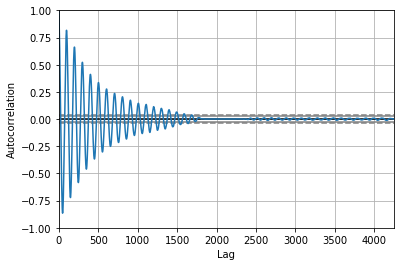

In [20]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(gyro_acc_rs[0])

We can use `pandas.Series.autocorr()` to find out the correlation of each measurement for a given lag.

First, we have to find out what the best frequency is, so we take the best correlation (averaged over measurements) across frequencies of 4 to 6 Hz.

We will consider that a tremor is present if two of the three directions of each measurement had a correlation greater than 0.6. This is an arbitrarily chosen value and could probably be further defined.

In [21]:
tremor_freqs = range(8, 13) # translates to 4-6 Hz: usual tremor freq

def best_lag(df, lags):
    mean_corrs = []
    for l in lags:
        # Apply autocorr on each column
        corr = df.apply(lambda c: c.autocorr(lag=l))
        mean_corrs.append(np.mean(corr))
    best_corr_index = mean_corrs.index(max(mean_corrs))
    return lags[best_corr_index]


def strong_corr_2of3(corrs):
    '''corrs should be a list of 3 correlations'''
    corr_thresh = 0.6
    count = reduce((lambda x,m: x + (m>corr_thresh)), corrs, 0)
    return count >= 2


def is_autocorr(df):
    '''A recording will be considered to contain a tremor if 2 directions of both
        gyroscope and accelerometer have autocorrelations over 0.6'''
    l = best_lag(df, tremor_freqs)
    corr = df.apply(lambda c: c.autocorr(lag=l))
    strong_corr = strong_corr_2of3(corr[0:3]) \
                and strong_corr_2of3(corr[3:6])
    return strong_corr
    

list(map(is_autocorr, gyro_acc_rs))

[True, False, True]

This gives us a basic result. The first and third recordings contain tremors. However, this is not a great approach because it looks at the entire recording, but there might be a tremor just in a section of it. We have to think of a way to look at periodicity in smaller sections of the recordings.

One idea to do that is to use `DataFrame.rolling()` to fragment the sensor data into windows on which we can apply `Series.autocorr()` to look at autocorrellation.

In [23]:
min_tremor_duration = 2 # seconds
min_tremor_samples = min_tremor_duration * sampling_freq


# Applies window of size 4 * lag which results in best correlation
def get_rolling_autocorr(df):
    lag = best_lag(df, tremor_freqs)
    windows = df.rolling(window=lag * 4)
    roll_corr = windows.apply(lambda c: c.autocorr(), raw=False)
    return roll_corr
    

def is_strongly_corr_gyro_acc(row):
    return strong_corr_2of3(row[0:3]) and strong_corr_2of3(row[3:6]) 


def get_strongly_corr_indexes(df):
    # df should have 6 columns, for 2 measurements
    roll_corr = get_rolling_autocorr(df)
    roll_corr = roll_corr.dropna()
    indexes = [i for (i, r) in roll_corr.iterrows() if is_strongly_corr_gyro_acc(r)]
    return indexes


def get_tremors_range(df):
    '''Given a recording, returns a list of tuples where each entry is the range of a tremor'''
    indexes = get_strongly_corr_indexes(df)
    # Make list of non-consecutive indexes:
    gaps = [[s, e] for s, e in zip(indexes, indexes[1:]) if s+1 < e]
    gaps = sum(gaps, [])
    # Add start and end:
    edges = indexes[:1] + gaps + indexes[-1:]
    # Make tuples from list:
    tuples = [(edges[i], edges[i+1]) for i in range(0, len(edges), 2)]
    tuples = [(s, e) for s, e in tuples if e-s+1 >= min_tremor_samples]
    return tuples

results = list(map(get_tremors_range, gyro_acc_rs))
print(results)

[[(31, 233), (2342, 4244)], [(6614, 7176), (7196, 9279)], [(31, 1409)]]


And that's it! We've created a function that, given a `DataFrame` returns the ranges of suspected tremors. We can see that we have identified two tremors in the second recording, which is twice as long as the first recording and was considered not to have a tremor using the rudimentary approach (which looked at the entire recording).

A few more steps would be needed to refine tremor identification:
* make `is_strongly_corr_gyro_acc()` applicable to more than 2 measurements, to enable comparison with whole dataset (including magnetometer readings).
* create an integrated pipeline which takes a file, checks for missing samples, strips the TS column (and magnetometer readings, depending on our results from previous step), and returns tremor ranges.

To classify tremors, we could look at their amplitude, pattern, and the relationship between frequency and amplitude. Given the tremor ranges, we could easily look at the data at those times to extract the relevant features.

### Part 2️⃣ 

To identify arm swing, let's first look at a recordings that include arm swings (even if they have some missing samples):

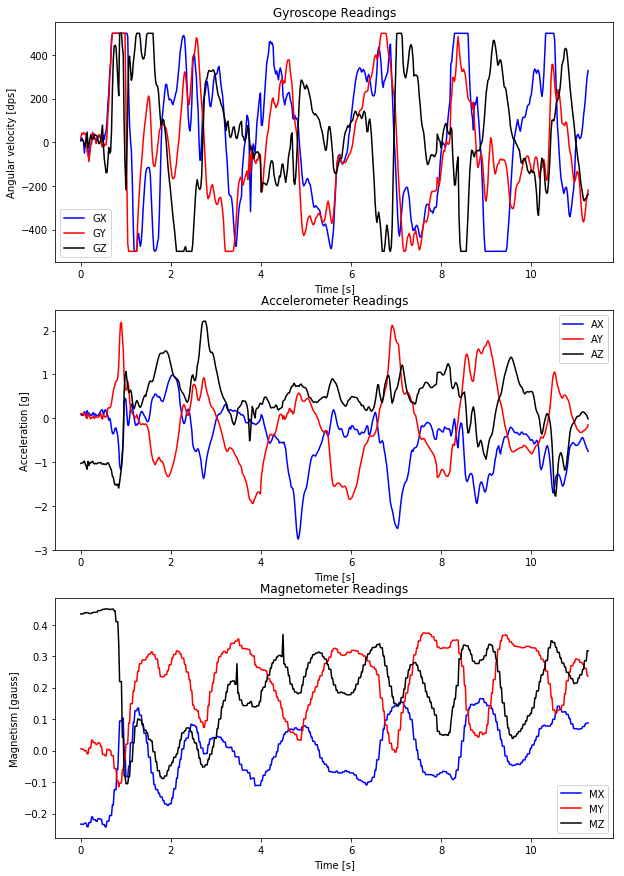

In [24]:
plot_all_measurements(raw_recordings[3])

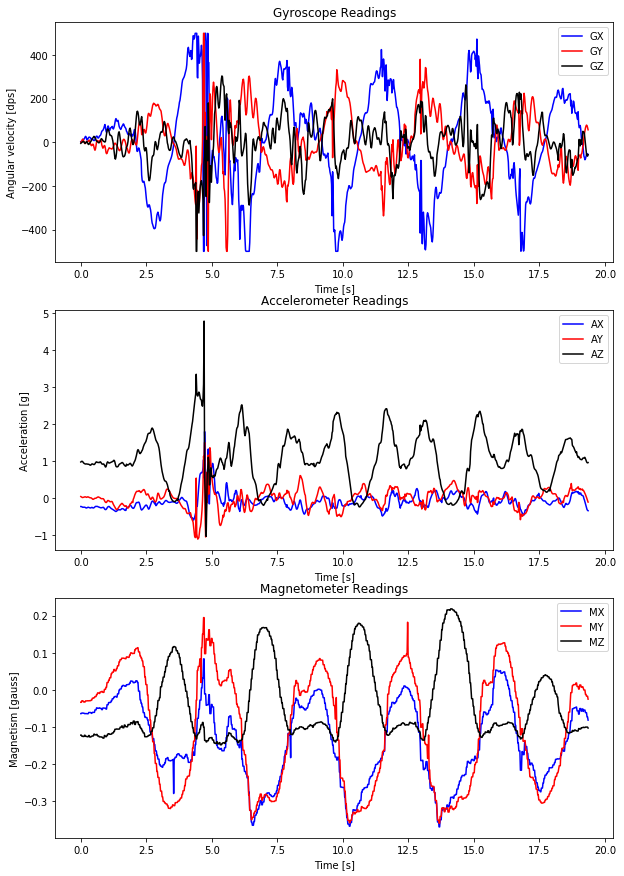

In [29]:
plot_all_measurements(raw_recordings[4])

The magnetometer data seems to be a very good way to spot arm swing, since it only encodes change in orientation, whereas the other two sensors show actual movement cause by walking. The magnetometer readings seem to be less noisy and more reliable for this use case.

Similarly to tremors, there is a periodicity in the data. However, it is has a larger frequency. The difficulty lies with creating a resilient arm swing identifier: the stride and speed vary from person to person and even with the same individual.

Let's look at the autocorrelation plots for these recordings.

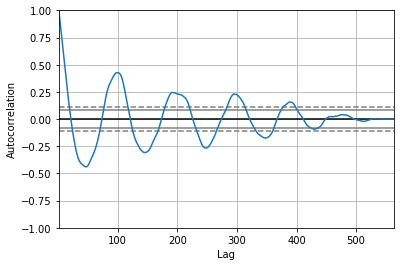

In [51]:
arm_swing_rs = list(map((lambda r: r.drop(['TS'], axis=1)), raw_recordings[3:5]))

autocorrelation_plot(arm_swing_rs[0])

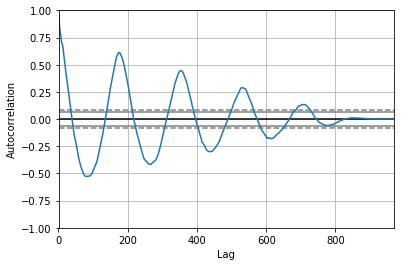

In [50]:
autocorrelation_plot(arm_swing_rs[1])

They seem too have quite different periods! The first is around 100 samples (2 seconds), while the second is around 180 (~3.5 seconds). Whereas tremors have a fairly strict frequency, walking is more diverse.

This could mean that we should take a different approach and looking at more than just the frequency and consistent pattern of the data.

### Part 3️⃣

In this section, I have researched and answered the questions in italics.

_1) What can the magnetometer be used for?_

A magnetometer measures the strength and direction of the magnetic field of the earth. Whereas the acceleratometer and gyroscope can show relative movement, the magnetometer can show absolute orientation. A compass is a simple magnetometer.
A magnetometer can be used to sense the orientation of an object with regards to the coordinate system of the earth.

From a practical perspective: it can be used to sense when a patient has fallen. In combination with an acceleratometer, gyroscope, and GPS it can form a resilient navigational system. Magnetometers are used to measure fluctuations in the magnetosphere of the Earth (e.g. caused by solar flares)

_2) What are possible sensor related errors in the measurements? How can we alleviate them?_

Errors can be instrumental (sensor malfunctioning). These could be:
* sensor bias - constant difference between output value and correct value. This can also drift over time
* random noise
* clipping errors - if the input value exceeds the output range of the sensor
* sensitivity error or nonlinearity in the transfer function (the function between input and output magnitude)
* hysteresis - the output value depends on previous inputs, so the same input could cause a different output depending on whether it was reached by increasing or decreasing the input
* quantization error - sensors with digital output actually give an approximation of the measured property
* nonorthogonality of measurement axes - the three dimensions of the sensor are not orthogonal so they depend on each other
* sampling at an inadequate frequency can cause aliasing errors - artefacts in the reconstructed signal. This can be countered by following the Nyquist-Shannon theorem, which states that if a signal has a maximum frequency $f_{max}$ Hz, then it should be sampled at least at $1/(2f_{max})$ seconds.

Errors can also be caused by external conditions in the environment, such as pressure, temperature, humidity, and surrounding magnetic fields (e.g. the magnetometer would go crazy next to a microwave oven because of its' magnetron).

To alleviate instrumental errors, it's important to use quality, precise sensors (e.g. using MEMS technology), but also to calibrate them correctly and regularly.

Environmental errors can be alleviated by controlling the environment as much as possible. For example, the sensors can be encapsulated in a sealed environment to avoid humidity. In the case of sensors inside a wearable, temperature should be fairly constant as they would be close to the body. Surrounding magnetic fields might be the trickiest to alleviate: a solution should be developed in software to ignore outliers based on the measurements of other sensors (i.e. if the magnetometer readings are erratic but there is very little change in the accelerometer and gyroscope, then it's an error - we wouldn't be able to change orientation without actually moving).

_3) Discuss ways to combine the presented motion data to reconstruct a full 3D motion. How can we estimate the sensor errors and take them into account for our calculations?_

_This is an open ended question, there are a variety of ways to answer it and numerous possible computational implementations._

A problem with reconstructing real movement from motion data (e.g. for navigation) is that sensor errors tend to add up if we are assuming a starting point. Integration drift is a problem when calculating the current position based on the previous position and the sensor data.

All three sensors are important to reconstruct 3D motion of the person wearing them. The accelerometer and gyroscope are needed to compute the 6 degrees of freedom of the subject (x, y, z, yaw, pitch & roll), while the magnetometer is needed to determine absolute orientation. A good idea to understand movement from sensor data is to create a mathematical model of the subject and to apply the change measured by sensors to the same points and see if the position of the model is probable.

There are mathematical ways for performing sensor fusion (e.g. Central Limit Theorem). Interestingly, Convolutional Neural Networks can also be used to combine many sensor data channels and extract relevant features. A CNN performing sensor fusion for Human Activity Recognition has been developed by Kasnesis et al. [1].

To estimate sensor errors, we can use an estimation algorithm such as the Kalman filter. This technique gives an optimal mean square error estimation for linear systems. A description of the Kalman filter algorithm:
1. Predict a value of the property measured
2. Estimate uncertainty of predicted value
3. Compute weighted average of predicted value and measured value (more weight is given to values which have more certainty)

Estimates produced through Kalman filter are closer to true values because the result of the weighted average has more certainty than either values used to calculate it.

Other approaches to estimating sensor errors are alpha filter and complimentary filter (for data fusion - more than one sensor). These are simpler and non-optimal, but less computationally intensive compared to the Kalman filter.


### My questions ❓

1) I've noticed that there is a weird dip in the peaks of one of the arm swing recordings. I might be wrong in assuming it is arm swing, and it might be something else. But if it is, I thought the dip could be caused by the impact of the foot hitting the ground while the arm is at it's peak. Is this correct or any idea what the real cause is?

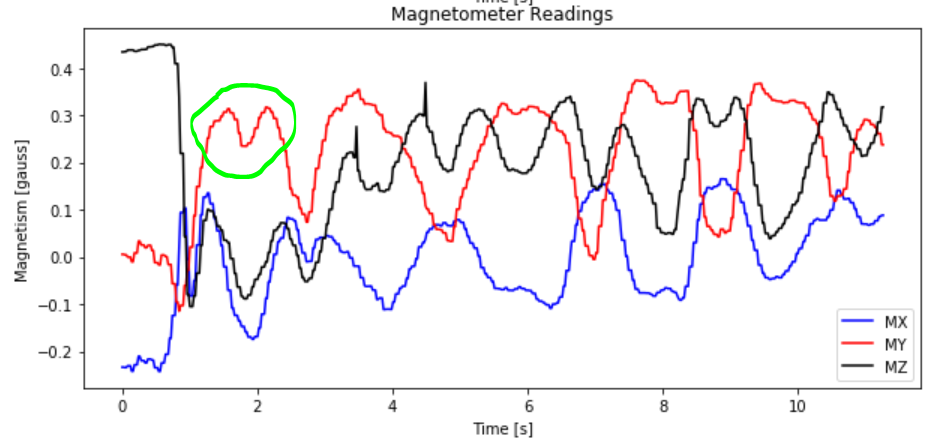

In [40]:
from IPython.display import Image
Image("magnetometer_arm_swing.png", width=600, height=350)

2) While I was reading about inertial navigation systems (accelerometer + gyroscope), I briefly read about *Schuler tuning* which is used to keep the system pointing towards the center of the earth. I thought that's more relevant for planes and submarines and not so much for this wearable, but then I was wondering: what if the wearer visits Australia, would the device think that the person is upside down? :)

Of course, for tremors you're more interested in relative movement, rather than in regards to the center of the earth, but I thought that you could easily implement some kind of alarm if the patient falls down (since advanced Parkinson's patients have balance problems) and that wouldn't work without Schuler tuning. My question is: are you calibrating the sensors to always point towards the earth or did you not find it necessary?

### References

[1] Kasnesis, P., Patrikakis, C. Z., & Venieris, I. S. (2018, September). PerceptionNet: A Deep Convolutional Neural Network for Late Sensor Fusion. https://arxiv.org/abs/1811.00170